
# Quantum machine learning using variational quantum circuits.

## Libraries

The set of libraries required to run the notebook

In [6]:

from quantum_classical_circuits import dataManagement as dm
from quantum_classical_circuits import quantum_circuits as qc
import pennylane as qml
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss



## Handling the credit card dataset

### Loading the dataset

The first step is to load the dataset and split the content into feature space and class, so that it is easier to handle the information afterwards.

In [7]:

# The dataset folder is included outside the workspace in a folder named datasets.
datafile_fraud = "../datasets/creditcard.csv"
start_index = 1
end_index = 29
class_index = 30
xVals, yVals = dm.read_data(datafile_fraud, start_index=start_index, end_index=end_index, class_index=class_index, k_lines=4)

# Fraud cases
iFraud = yVals[yVals == 1]
indexesFraud = list(iFraud.keys())

# Clean cases
iClean = yVals[yVals == 0]
indexesClean = list(iClean.keys())

print("Fraud cases: ", len(indexesFraud))
print("Clean cases: ", len(indexesClean))

# Shift label from {0, 1} to {-1, 1}
# yVals = yVals * 2 - np.ones(len(yVals))  # shift label from {0, 1} to {-1, 1}


            Time        V1        V2        V3        V4        V5        V6  \
0            0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388   
1            0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361   
...          ...       ...       ...       ...       ...       ...       ...   
284805  172788.0 -0.240440  0.530483  0.702510  0.689799 -0.377961  0.623708   
284806  172792.0 -0.533413 -0.189733  0.703337 -0.506271 -0.012546 -0.649617   

              V7        V8        V9       V10       V11       V12       V13  \
0       0.239599  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390   
1      -0.078803  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095   
...          ...       ...       ...       ...       ...       ...       ...   
284805 -0.686180  0.679145  0.392087 -0.399126 -1.933849 -0.962886 -1.042082   
284806  1.577006 -0.414650  0.486180 -0.915427 -1.040458 -0.031513 -0.188093   

             V14       V15       V16  


### Preparing the train and test set

In order to balance the dataset a oversampling technique (SMOTE) is utilized in combination with an undersampling one (Near Miss). The sampling technique achieves a middle point where the newly sampled of the minority class cases and the undersampled cases of the majority class are equal without forcing one another.

In [8]:

X_train, X_test, y_train, y_test = train_test_split(xVals, yVals, test_size = 0.25, random_state = 0)
print("Before OverSampling, counts of label FRAUD('1') in the training set: {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label CLEAN('0') in the training: {} \n".format(sum(y_train == 0)))

sm = SMOTE(sampling_strategy = 1, random_state = 6)
X_train_os, y_train_os = sm.fit_resample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_os.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_os.shape))

print("After OverSampling, counts of label FRAUD('1'): {}".format(sum(y_train_os == 1)))
print("After OverSampling, counts of label CLEAN('0'): {}".format(sum(y_train_os == 0)))


Before OverSampling, counts of label FRAUD('1') in the training set: 372
Before OverSampling, counts of label CLEAN('0') in the training: 213233 

After OverSampling, the shape of train_X: (426466, 28)
After OverSampling, the shape of train_y: (426466,) 

After OverSampling, counts of label FRAUD('1'): 213233
After OverSampling, counts of label CLEAN('0'): 213233


# Model: Classical dense layer for binary classification

## Training the quantum circuit

In [9]:

iterations = 10 # Number of iterations through the training set
l_rate = 0.01 # Learning rate of the optimizer
n_layers = 2
n_qubits = 5
n_operation = 3 # The rotation takes 3 variables
# c_type = 'AE'
x_dataset = tf.constant(X_train_os)
y_dataset = tf.constant(y_train_os)


In [10]:

dir_weights = "./model_weights/classical_weights" # Pretrained model weights
# weight_shapes = {"qcircuit_parameters": [n_layers, n_qubits, n_operation]}
input_features = 28
units_l1 = 32
units_l2 = 32
load_weights = True
history = None
inputs = tf.keras.Input(shape=(28,), name='Input')
clayer_1 = tf.keras.layers.Dense(units=units_l1, activation="relu", name='Classical_1', kernel_initializer=tf.initializers.RandomNormal(seed=6))
clayer_2 = tf.keras.layers.Dense(units=units_l2, activation="relu", name='Classical_2', kernel_initializer=tf.initializers.RandomNormal(seed=6))
clayer_3 = tf.keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid, name='Sigmoid', kernel_initializer=tf.initializers.RandomNormal(seed=6))

# Functional diagram
x = clayer_1(inputs)
x = clayer_2(x)
outputs = clayer_3(x)

# Equivalent to:
# model = tf.keras.models.Sequential([clayer_1, clayer_2, clayer_3])


model = tf.keras.Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l_rate), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=["binary_accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

if not load_weights:
    history = model.fit(x_dataset, y_dataset, epochs=iterations)
else:
    history = model.fit(x_dataset[:1], y_dataset[:1], epochs=1, batch_size=100)
    


Epoch 1/10
13328/13328 [==============================] - 21s 2ms/step - loss: 0.0196 - binary_accuracy: 0.9944 - precision_1: 0.9930 - recall_1: 0.9958
Epoch 2/10
13328/13328 [==============================] - 20s 1ms/step - loss: 0.0089 - binary_accuracy: 0.9980 - precision_1: 0.9971 - recall_1: 0.9989
Epoch 3/10
13328/13328 [==============================] - 20s 1ms/step - loss: 0.0077 - binary_accuracy: 0.9985 - precision_1: 0.9978 - recall_1: 0.9991
Epoch 4/10
13328/13328 [==============================] - 19s 1ms/step - loss: 0.0067 - binary_accuracy: 0.9988 - precision_1: 0.9982 - recall_1: 0.9993
Epoch 5/10
13328/13328 [==============================] - 18s 1ms/step - loss: 0.0070 - binary_accuracy: 0.9988 - precision_1: 0.9983 - recall_1: 0.9994
Epoch 6/10
13328/13328 [==============================] - 18s 1ms/step - loss: 0.0059 - binary_accuracy: 0.9989 - precision_1: 0.9985 - recall_1: 0.9994
Epoch 7/10
13328/13328 [==============================] - 18s 1ms/step - loss: 0.0

### Saving model weights for future use

In [11]:

if load_weights:
    model.load_weights(filepath=dir_weights)
else:
    model.save_weights(filepath=dir_weights)


In [12]:
print(history.history)

{'loss': [0.019637171179056168, 0.008872521109879017, 0.00772359874099493, 0.006655370816588402, 0.006963359657675028, 0.00592015590518713, 0.005424752831459045, 0.005229257512837648, 0.005471888463944197, 0.005856597330421209], 'binary_accuracy': [0.9943794012069702, 0.9980021715164185, 0.9984641075134277, 0.9987900853157043, 0.9988205432891846, 0.9989166855812073, 0.9991206526756287, 0.9990925192832947, 0.9991323947906494, 0.9991629123687744], 'precision_1': [0.9930129647254944, 0.9970976710319519, 0.9978080987930298, 0.9982386231422424, 0.9982714056968689, 0.9984771609306335, 0.9986973404884338, 0.9986972808837891, 0.9987768530845642, 0.9987675547599792], 'recall_1': [0.995765209197998, 0.99891197681427, 0.9991230368614197, 0.9993434548377991, 0.9993715882301331, 0.9993575215339661, 0.9995450973510742, 0.9994888305664062, 0.9994888305664062, 0.9995591640472412]}


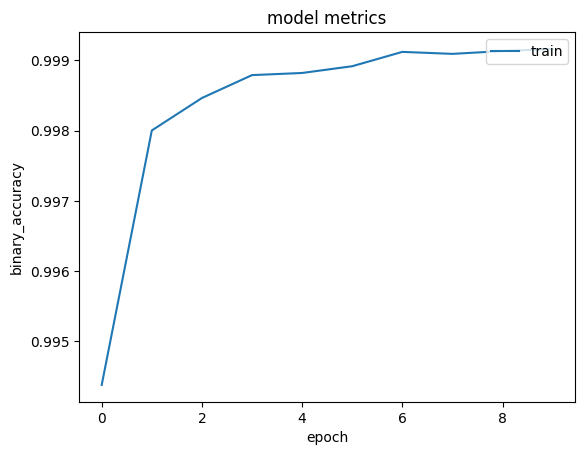

In [13]:

if not load_weights:
    plt.plot(history.history['binary_accuracy'])
    plt.title('model metrics')
    plt.ylabel('binary_accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper right')
    plot_dir = "./plots/classic_ba.png"
    plt.savefig(fname=plot_dir)


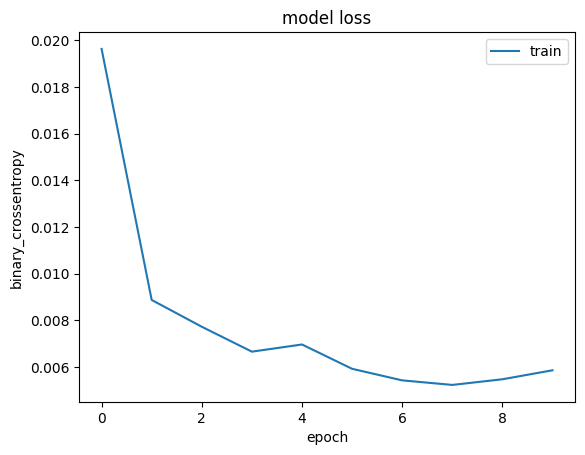

In [14]:

if not load_weights:
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('binary_crossentropy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper right')
    plot_dir = "./plots/classic_loss.png"
    plt.savefig(fname=plot_dir)


## Testing the quantum circuit

In [15]:

x_dataset_test = tf.constant(X_test)
y_dataset_test = tf.constant(y_test)
x_test_fraud = x_dataset_test[y_dataset_test == 1]
y_test_fraud = y_dataset_test[y_dataset_test == 1]
balanced_test_cases = x_test_fraud.shape[0]
x_test_clean = x_dataset_test[y_dataset_test == 0][:balanced_test_cases]
y_test_clean = y_dataset_test[y_dataset_test == 0][:balanced_test_cases]


In [16]:

test_size = -1
x_dataset_test = tf.constant(X_test)[:test_size]
y_dataset_test = tf.constant(y_test)[:test_size]
result = model.evaluate(x=x_dataset_test, y=y_dataset_test)
dict(zip(model.metrics_names, result))


2226/2226 [==============================] - 3s 1ms/step - loss: 0.0548 - binary_accuracy: 0.9989 - precision_1: 0.6258 - recall_1: 0.8500


{'loss': 0.054786987602710724,
 'binary_accuracy': 0.9988904595375061,
 'precision_1': 0.6257668733596802,
 'recall_1': 0.8500000238418579}

In [17]:

predictions_fraud = model.predict(x=x_test_fraud)
predictions_clean = model.predict(x=x_test_clean)


4/4 [==============================] - 0s 1ms/step


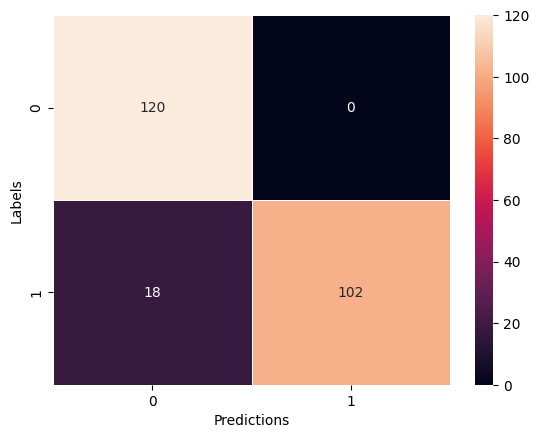

In [18]:

dir_conf_mat = "./plots/classical.png"

fraud_vector = np.ones(balanced_test_cases)
clean_vector = np.zeros(balanced_test_cases)

p_fraud_vector = np.ones(balanced_test_cases)
p_clean_vector = np.zeros(balanced_test_cases)

for i in range(balanced_test_cases):
    if predictions_fraud[i] < 0.5 :
        p_fraud_vector[i] = 0
    if predictions_clean[i] > 0.5 :
        p_clean_vector[i] = 1

y_true = np.concatenate([fraud_vector, clean_vector], dtype=int, casting="unsafe")
y_pred = np.concatenate([p_fraud_vector, p_clean_vector], dtype=int, casting="unsafe")
data_cols = {"Labels" : y_true, "Predictions" : y_pred}
df = pd.DataFrame(data_cols, columns=["Labels", "Predictions"])
confusion_matrix = pd.crosstab(df["Labels"], df["Predictions"], rownames=["Labels"], colnames=["Predictions"])
sn.heatmap(confusion_matrix, annot=True, linewidths=.5, fmt="d")
plt.savefig(fname=dir_conf_mat)
plt.show()


## Plots

Plots help visualize the specific distance between the desired value (eigenvalue +1 or -1) and the predicted value.

In [ ]:

from turtle import color


pfraud_points = p_fraud_vector.shape[0]
pclean_points = p_clean_vector.shape[0]

bottom_val = -1.5
top_val = 1.5
x_left = -0.5
x_right = pfraud_points + 0.5

x_fraud = np.linspace(0, pfraud_points, pfraud_points)
x_clean = np.linspace(0, pclean_points, pclean_points)

positive_line = np.full(shape=pfraud_points, fill_value=1)
middle_line = np.full(shape=pfraud_points, fill_value=0.5)
negative_line = np.full(shape=pclean_points, fill_value=0)

fig, axs = plt.subplots(2, 1, figsize=(10,5))

axs[0].scatter(x_fraud, p_fraud_vector, c='r')
axs[0].plot(x_fraud, positive_line, color='g', linestyle="dashed", label="Fraud")
axs[0].plot(x_fraud, middle_line, color='y', linestyle="-.")
axs[0].plot(x_fraud, negative_line, color='k', linestyle="dashed")
axs[0].set_title('Fraud cases')
axs[0].set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
axs[0].set_xlim(x_left, x_right)
axs[0].set_ylim(bottom_val, top_val)
axs[0].set_xticks([])
axs[0].legend(loc='lower right')

axs[1].scatter(x_clean, p_clean_vector, c='r')
axs[1].plot(x_clean, positive_line, color='k', linestyle="dashed")
axs[1].plot(x_clean, middle_line, color='y', linestyle="-.")
axs[1].plot(x_clean, negative_line, color='g', linestyle="dashed", label="Valid")
axs[1].set_title('Valid cases')
axs[1].set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
axs[1].set_xlim(x_left, x_right)
axs[1].set_ylim(bottom_val, top_val)
axs[1].set_xticks([])
axs[1].legend(loc='lower right')

plot_dir = "./plots/hybrid_seq_scatter.png"
plt.savefig(fname=plot_dir)


## Visualizing the model

In [ ]:

dir_qcircuit_image = "./model_diagrams/hybrid_seq.png"
tf.keras.utils.plot_model(model=model, to_file=dir_qcircuit_image, show_shapes=True)


In [ ]:

circuit_dir = "./model_diagrams/qcircuit_ae_qgates_hs.png"
fig, ax = qml.draw_mpl(qc.qcircuit_amplitude_embedding_kl, decimals = 2)(x_dataset[0], model.layers[1].weights[0])
plt.savefig(fname=circuit_dir)
